# RVC Exploratory Data Analysis

**Last Modified**: Aug 20, 2025

In this notebook, we calibrate the RVC historic data and apply a prediction model trained on summarized Vectronics data.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import AutoDateLocator, AutoDateFormatter
import seaborn as sns
import os
import sys
import yaml
from sklearn.preprocessing import LabelEncoder
import torch
from collections import Counter
sys.path.append('.')
sys.path.append('../')
sys.path.append('../../')

from scripts.run_RVC_preprocessing import (load_RVC_data,
                                           load_RVC_metadata,)

from src.utils.functionalities import (median_pairwise_distance,
                                       mmd_test)
from src.utils.RVC_preprocessing import preprocess_data
import config as config
import src.utils.io as io

In [3]:
# Graphing Parameters
import matplotlib as mpl
mpl.rcParams['lines.markersize'] = 12
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['xtick.labelsize'] = 25
mpl.rcParams['ytick.labelsize'] = 25
mpl.rcParams["axes.labelsize"] = 25
mpl.rcParams['legend.fontsize'] = 20
mpl.rcParams['axes.titlesize'] = 25
mpl.rcParams['text.usetex'] = True

## 1. Data Cleaning and Exploratory Data Analysis

In [36]:
df = load_RVC_data()
metadata_df = load_RVC_metadata()

df_summary = df.groupby('animal_id').agg({'UTC date [yyyy-mm-dd]': ['min', 'max', 'count', 'nunique']})
df_summary.columns = ['Start date', 'End date', 'Total no. of windows', 'No. of unique dates']
df_summary


,Start date,End date,Total no. of windows,No. of unique dates
animal_id,,,,
Accra,1970-01-05,2012-08-30,17383,24
Adiga,1970-01-02,2016-03-23,1035272,597
Aztec,1970-01-01,2014-10-01,233280,227
Bali,2015-01-31,2016-03-05,717374,373
Bobedi,1970-01-01,2012-06-22,110643,130
Bongwe,1970-01-03,2016-02-06,487128,276
Brian,1970-01-04,2012-05-31,24424,28
Dar,2012-04-15,2012-05-05,18087,21
Fiji,2016-03-23,2016-11-23,463662,246


In [5]:
# Load RVC config
with open(config.RVC_PREPROCESSING_YAML) as f:
    RVC_preprocessing_config = yaml.safe_load(f)

RVC_feature_cols = RVC_preprocessing_config['feature_cols']
RVC_helper_cols = RVC_preprocessing_config['helper_cols']

In [6]:
from src.utils.RVC_preprocessing import (remove_duplicates,
                                         calibrate_RVC_data,
                                         threshold_RVC)

df = remove_duplicates(df)

# Calibration
calibrated_df = calibrate_RVC_data(df, metadata_df)

# Truncation
truncated_df = threshold_RVC(calibrated_df)

Removed 72191 duplicates.


/home/medhaaga/BotswanaML/notebooks/../src/utils/RVC_calibration.py:272: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-16.28823529 -16.53921569 -16.53137255 ... -16.36666667 -16.35882353
 -15.39411765]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[mask, 'acc_x_ptp_max'] = df.loc[mask, 'acc_x_ptp_max'].apply(lambda x: (x - offset_X) / sensitivity_X)
/home/medhaaga/BotswanaML/notebooks/../src/utils/RVC_calibration.py:273: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-16.79233871 -16.8891129  -16.88104839 ... -16.52620968 -16.57459677
 -16.07459677]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[mask, 'acc_y_ptp_max'] = df.loc[mask, 'acc_y_ptp_max'].apply(lambda x: (x - offset_Y) / sensitivity_Y)
/home/medhaaga/BotswanaML/

No data found for animal_id Augustus in the date range NaT to NaT
No data found for animal_id Bali in the date range 2013-12-23 00:00:00 to 2014-09-17 00:00:00
No data found for animal_id MJ in the date range NaT to NaT
No data found for animal_id Scorpion in the date range 2012-10-08 00:00:00 to 2012-10-30 00:00:00
No data found for animal_id Scorpion in the date range 2012-11-02 00:00:00 to 2013-10-05 00:00:00
No data found for animal_id Seronera in the date range NaT to NaT
No data found for animal_id Yolo in the date range 2012-09-21 00:00:00 to 2012-10-23 00:00:00
No data found for animal_id Gobi in the date range NaT to NaT
Number of rows without calibration metadata: 53698/7177165
Number of outliers removed: 2623216/7123467.


Feature: acc_x_ptp_max, number of outliers: 1950279
Feature: acc_y_ptp_max, number of outliers: 1406936
Feature: acc_z_ptp_max, number of outliers: 2618241
Feature: acc_x_ptp_mean, number of outliers: 15
Feature: acc_y_ptp_mean, number of outliers: 18
Feature: acc_z_ptp_mean, number of outliers: 25
Feature: acc_x_mean, number of outliers: 1252503
Feature: acc_y_mean, number of outliers: 1262155
Feature: acc_z_mean, number of outliers: 1395415


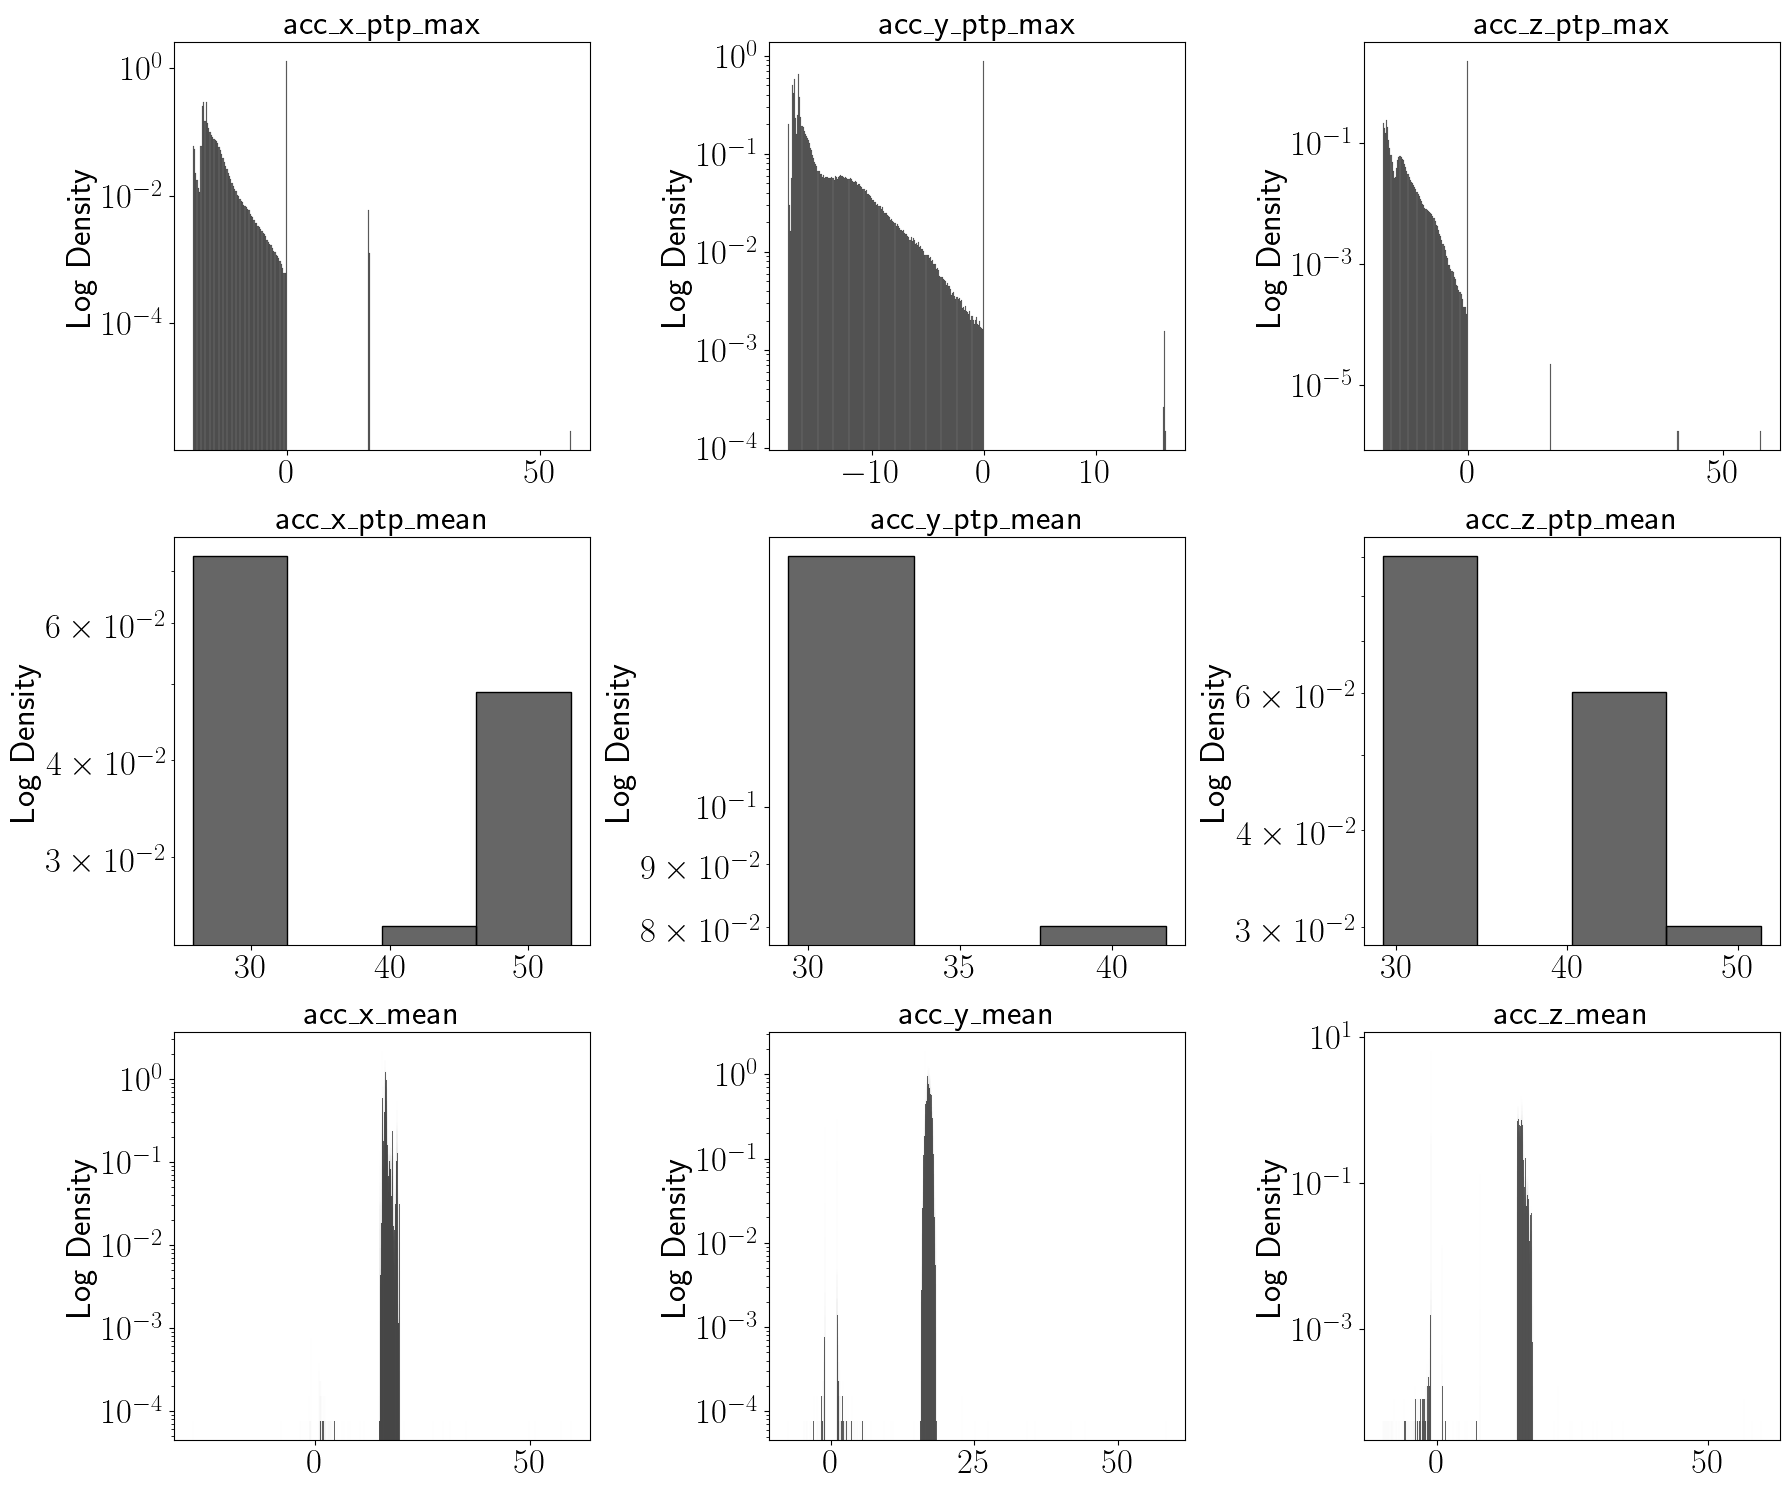

In [9]:
ncols=3
nrows = int(np.ceil(len(RVC_feature_cols) / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 5*nrows))
axs = axes.flatten()

for i, col in enumerate(RVC_feature_cols):
    if 'ptp' in col:
        outliers = calibrated_df[(calibrated_df[col] < 0) | (calibrated_df[col] > 2*calibrated_df['range'])]
        print(f"Feature: {col}, number of outliers: {len(outliers)}")

        outliers = outliers[(outliers[col] >= -5 * outliers['range']) & (outliers[col] <= 5 * outliers['range'])]

    else:
        outliers = calibrated_df[(calibrated_df[col] < -1) | (calibrated_df[col] > 1)]
        print(f"Feature: {col}, number of outliers: {len(outliers)}")

        outliers = outliers[(outliers[col] >= -5 * outliers['range']) & (outliers[col] <= 5 * outliers['range'])]

    sns.histplot(
                outliers[col],
                kde=False,
                ax=axs[i],
                stat='density',
                # bins=30,
                color='black',
                alpha=0.6
            )

    axs[i].set_title(col)
    axs[i].set_ylabel('Log Density')
    axs[i].set_xlabel('')
    axs[i].set_yscale("log")


plt.tight_layout()
plt.show()
    

In [37]:
# preprocess RVC data
RVC_df = preprocess_data(
        df=df,
        metadata_df=metadata_df,
        feature_cols=RVC_preprocessing_config['feature_cols'],
        helper_cols=RVC_preprocessing_config['helper_cols'],
        summary_dir=io.get_results_dir()
    )

Removed 72191 duplicates.


/home/medhaaga/BotswanaML/notebooks/../src/utils/RVC_calibration.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'collar_number'] = 0.0
/home/medhaaga/BotswanaML/notebooks/../src/utils/RVC_calibration.py:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'range'] = 0.0
/home/medhaaga/BotswanaML/notebooks/../src/utils/RVC_calibration.py:272: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-16.28823529 -1

No data found for animal_id Augustus in the date range NaT to NaT
No data found for animal_id Bali in the date range 2013-12-23 00:00:00 to 2014-09-17 00:00:00
No data found for animal_id MJ in the date range NaT to NaT
No data found for animal_id Scorpion in the date range 2012-10-08 00:00:00 to 2012-10-30 00:00:00
No data found for animal_id Scorpion in the date range 2012-11-02 00:00:00 to 2013-10-05 00:00:00
No data found for animal_id Seronera in the date range NaT to NaT
No data found for animal_id Yolo in the date range 2012-09-21 00:00:00 to 2012-10-23 00:00:00
No data found for animal_id Gobi in the date range NaT to NaT
Number of rows without calibration metadata: 53698/7177165
Number of outliers removed: 2623216/7123467.


Create a histogram of outliers. Send it to John.

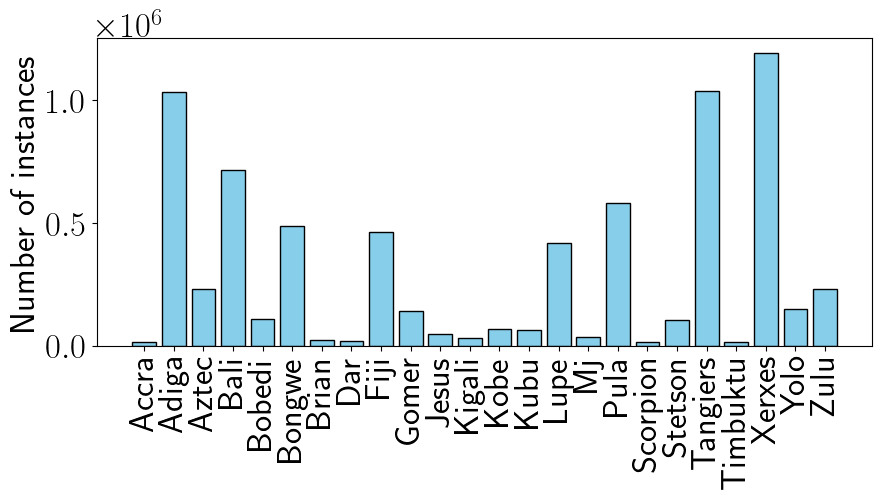

In [40]:
plt.figure(figsize = (10,4))
plt.bar(df_summary.index, df_summary['Total no. of windows'], color='skyblue', edgecolor='black')
plt.ylabel('Number of instances')
plt.xticks(rotation = 90)
plt.show()

Notice the presence of outliers for several dogs, especially Bongwe.

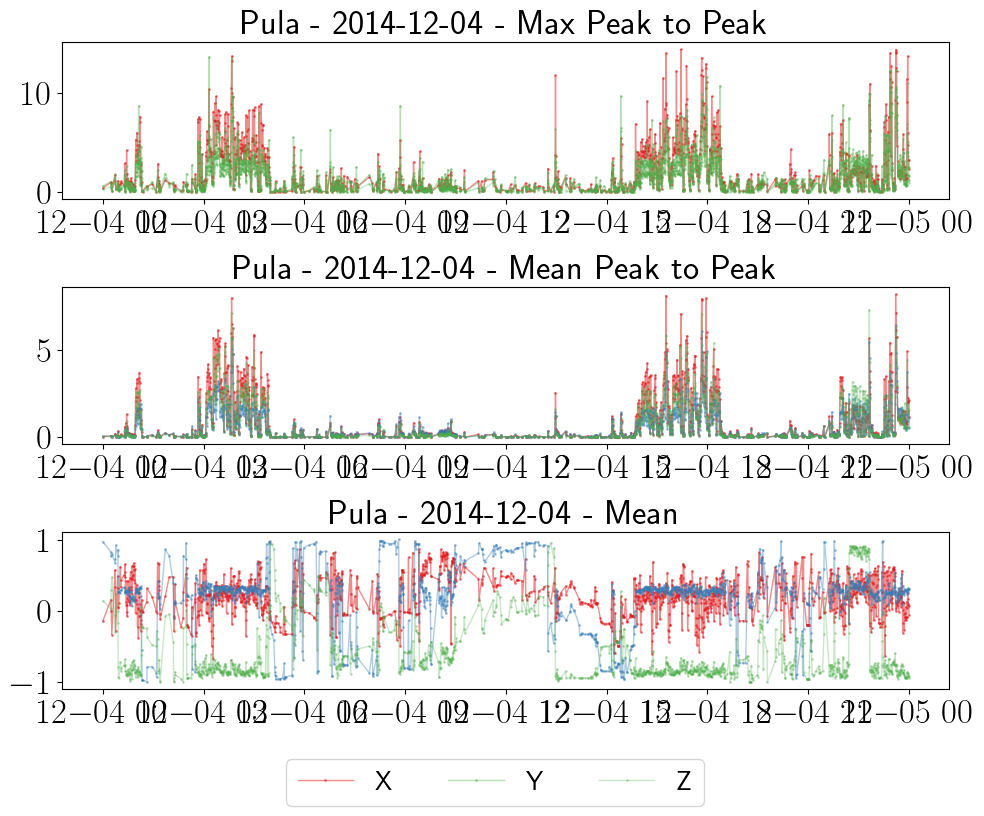

In [10]:
dogs = RVC_df.animal_id.unique()
selected_dog = np.random.choice(dogs)
df_sub = RVC_df[RVC_df.animal_id == selected_dog]
dates = df_sub['UTC date [yyyy-mm-dd]'].unique()
date = np.random.choice(dates)

palette = sns.color_palette("Set1", n_colors=3)

fig, axs = plt.subplots(3, 1, figsize=(10,7.5))

df_tmp = df_sub[df_sub['UTC date [yyyy-mm-dd]'] == date]
loc = AutoDateLocator()
form = AutoDateFormatter(loc)
axs[0].xaxis.set_major_locator(loc)
axs[0].xaxis.set_major_formatter(form)  
axs[0].plot(df_tmp['UTC time [yyyy-mm-dd HH:MM:SS]'], df_tmp['acc_x_ptp_max'], marker='o', markersize=1, alpha=0.5, linestyle='-', color=palette[0], label='X')
axs[0].plot(df_tmp['UTC time [yyyy-mm-dd HH:MM:SS]'], df_tmp['acc_y_ptp_max'], marker='o', markersize=1, alpha=0.4, linestyle='-', color=palette[2], label='Y')
axs[0].plot(df_tmp['UTC time [yyyy-mm-dd HH:MM:SS]'], df_tmp['acc_z_ptp_max'], marker='o', markersize=1, alpha=0.3, linestyle='-', color=palette[2], label='Z')
axs[0].set_title(f'{selected_dog} - {str(date)} - Max Peak to Peak')
# axs[0].legend(loc='best')

axs[1].xaxis.set_major_locator(loc)
axs[1].xaxis.set_major_formatter(form)  
axs[1].plot(df_tmp['UTC time [yyyy-mm-dd HH:MM:SS]'], df_tmp['acc_x_ptp_mean'], marker='o', markersize=1, alpha=0.5, linestyle='-', color=palette[0])
axs[1].plot(df_tmp['UTC time [yyyy-mm-dd HH:MM:SS]'], df_tmp['acc_y_ptp_mean'], marker='o', markersize=1, alpha=0.4, linestyle='-', color=palette[1])
axs[1].plot(df_tmp['UTC time [yyyy-mm-dd HH:MM:SS]'], df_tmp['acc_z_ptp_mean'], marker='o', markersize=1, alpha=0.3, linestyle='-', color=palette[2])
axs[1].set_title(f'{selected_dog} - {str(date)} - Mean Peak to Peak')
# axs[1].legend(loc='best')

axs[2].xaxis.set_major_locator(loc)
axs[2].xaxis.set_major_formatter(form)  
axs[2].plot(df_tmp['UTC time [yyyy-mm-dd HH:MM:SS]'], df_tmp['acc_x_mean'], marker='o', markersize=1, alpha=0.5, linestyle='-', color=palette[0])
axs[2].plot(df_tmp['UTC time [yyyy-mm-dd HH:MM:SS]'], df_tmp['acc_y_mean'], marker='o', markersize=1, alpha=0.4, linestyle='-', color=palette[1])
axs[2].plot(df_tmp['UTC time [yyyy-mm-dd HH:MM:SS]'], df_tmp['acc_z_mean'], marker='o', markersize=1, alpha=0.3, linestyle='-', color=palette[2])
axs[2].set_title(f'{selected_dog} - {str(date)} - Mean')
# axs[2].legend(loc='best')

fig.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5,-0.1))
plt.tight_layout()
plt.show()

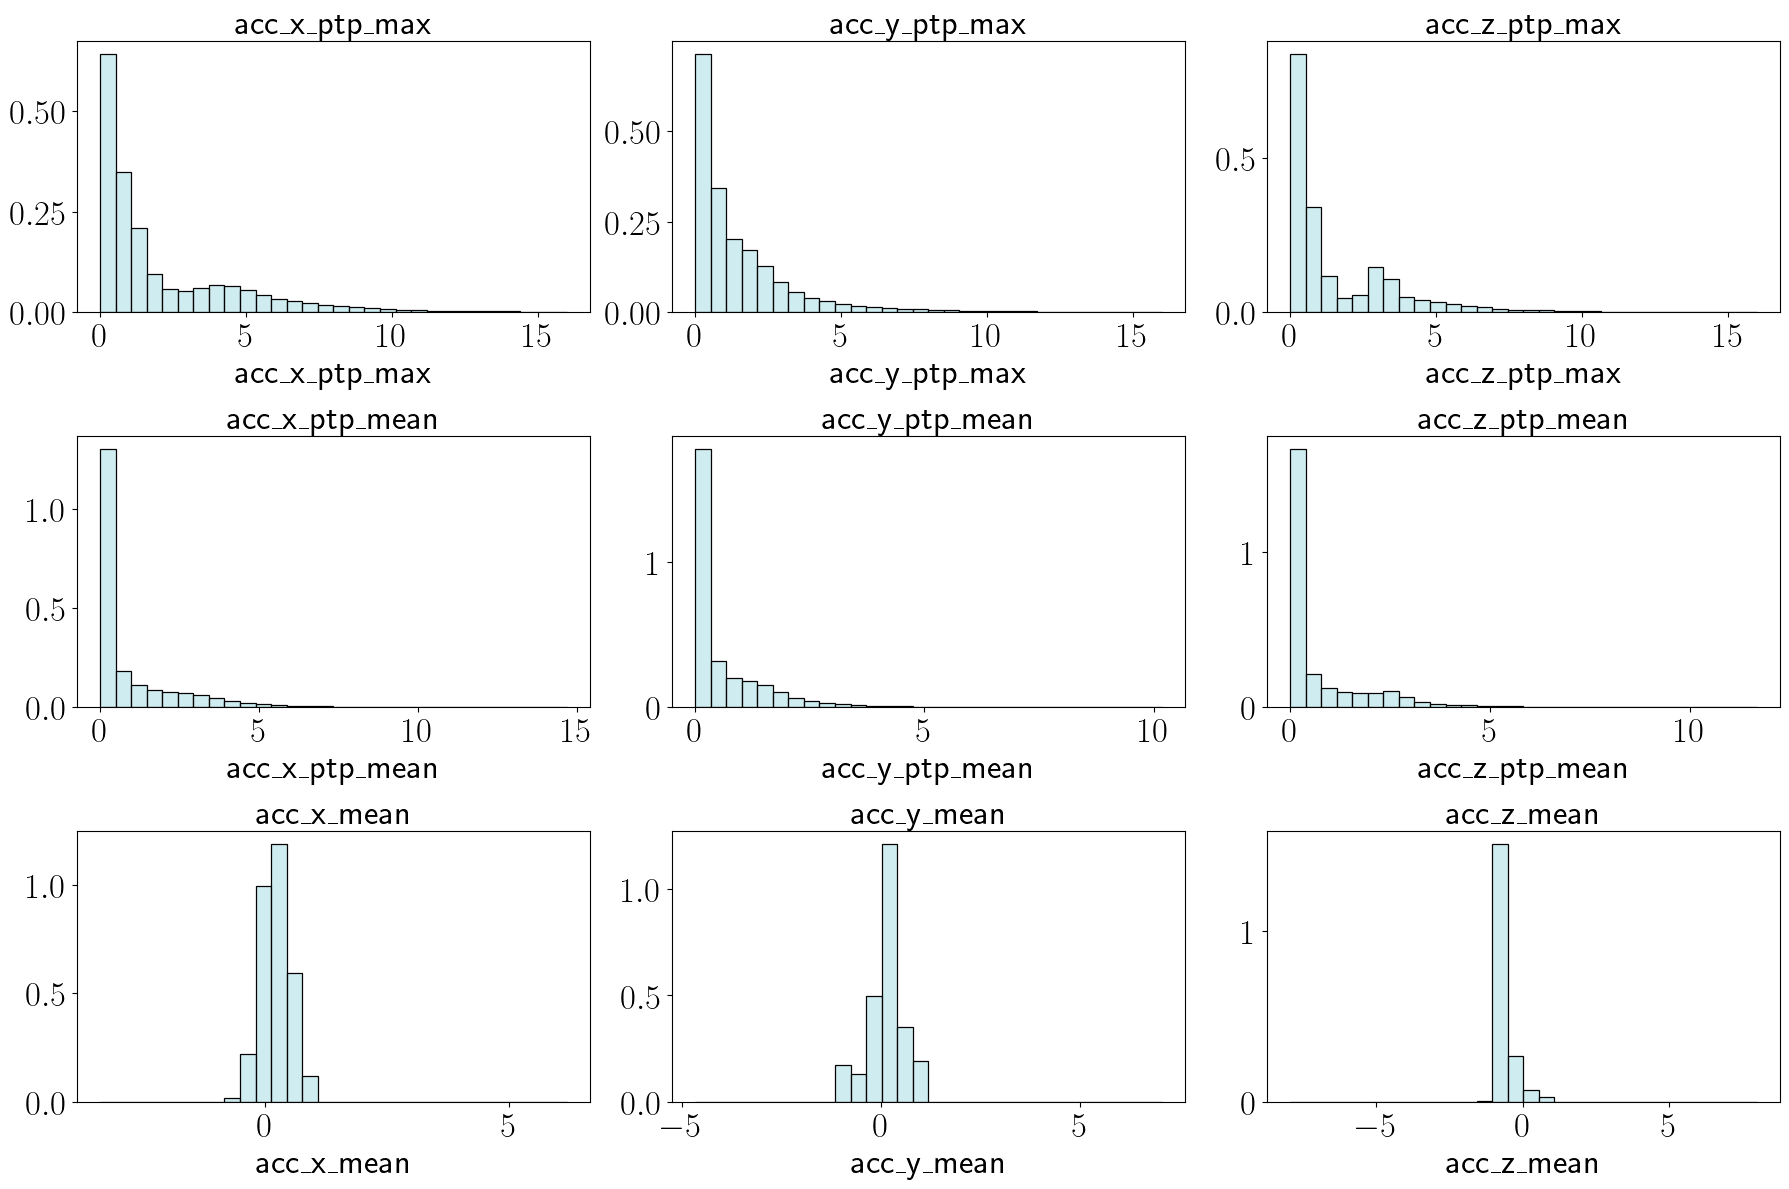

In [9]:
ncols = 3
nrows = int(np.ceil(len(RVC_feature_cols) / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 4*nrows))
axs = axes.flatten()

for i, col in enumerate(RVC_feature_cols):
        ax = axs[i]
        sns.histplot(
                RVC_df[col],
                kde=False,
                ax=ax,
                stat='density',
                bins=30,
                color='powderblue',
                alpha=0.6
            )

        ax.set_title(col)
        ax.set_ylabel('')

plt.tight_layout()
plt.show()

In [11]:
# Load Vectronics config
with open(config.VECTRONICS_PREPROCESSING_YAML) as f:
    Vectronics_preprocessing_config = yaml.safe_load(f)

Vectronics_feature_cols = Vectronics_preprocessing_config['feature_cols']
Vectronics_helper_cols = Vectronics_preprocessing_config['helper_cols']

In [12]:
vectronics_df = pd.read_csv(io.get_Vectronics_preprocessed_path())
vectronics_df = vectronics_df[Vectronics_feature_cols + Vectronics_helper_cols]

/tmp/ipykernel_2396443/2759787644.py:38: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


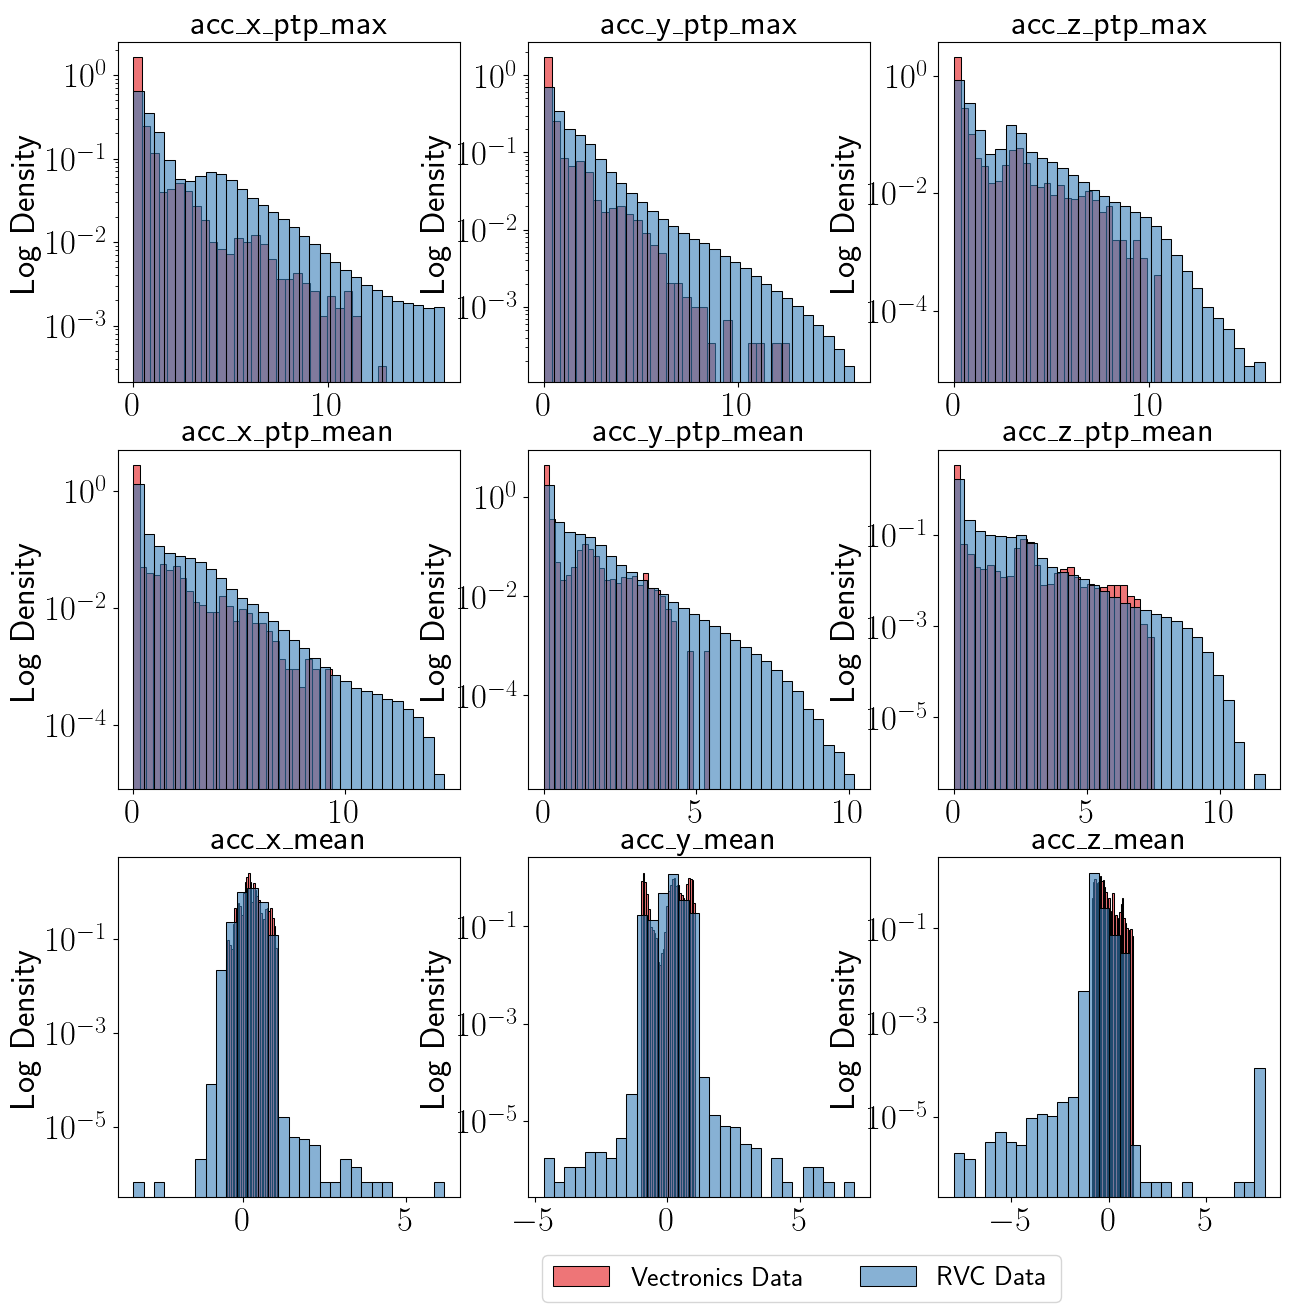

In [39]:
fig, axes = plt.subplots(len(Vectronics_feature_cols)//3, 3, figsize=(15, 5*(len(Vectronics_feature_cols)//3)))
palette = sns.color_palette("Set1", n_colors=2)
axes = axes.flatten()
for i, col in enumerate(Vectronics_feature_cols):
        ax = axes[i]

        sns.histplot(
                vectronics_df[col],
                kde=False,
                label='Vectronics Data',
                ax=ax,
                stat='density',
                bins=30,
                color=palette[0],
                alpha=0.6
            )

        sns.histplot(
                RVC_df[col],
                kde=False,
                label='RVC Data',
                ax=ax,
                stat='density',
                bins=30,
                color=palette[1],
                alpha=0.6
            )

        ax.set_title(col)
        ax.set_ylabel('Log Density')
        ax.set_yscale("log")
        ax.set_xlabel('')

# Get legend info from the first axes
handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles, labels, loc='lower center', bbox_to_anchor=(2.0, -2.75), ncol=2)

plt.tight_layout()
plt.show()


In [41]:
Xs = vectronics_df[Vectronics_feature_cols].values
Xt = RVC_df[Vectronics_feature_cols].values

# shuffle the rows 
np.random.shuffle(Xs)
np.random.shuffle(Xt)

print(f"Number of samples in source data: {Xs.shape[0]}")
print(f"Number of samples in target data: {Xt.shape[0]}")

Number of samples in source data: 7070
Number of samples in target data: 4500251


## 4. Determine Covariate Shift

We compute the sliced Wasserstein distance and Sinkhorn divergence between the two datasets with increasing number of samples $n$ to check if the computed distance decreases as a function of $n$.

In [15]:
n, m = 2000, 2000
sigma = median_pairwise_distance(Xs[:n, :], Xt[:m, :])
stat, permuted_stat, pval = mmd_test(X=Xs[:n, :], Y=Xt[:m, :], sigma=sigma, num_permutations=1000, seed=42)

print(f"MMD^2 statistic: {stat:.4f}")
if pval < 0.05:
    print(f"P-value: {pval:.4f} - The two distributions are significantly different (reject H0).")
else:
    print(f"P-value: {pval:.4f} - The two distributions are not significantly different (fail to reject H0).")

MMD^2 statistic: 0.1085
P-value: 0.0000 - The two distributions are significantly different (reject H0).


## 5. Apply the Prediction Model

In [42]:
device = torch.device(f"cuda:{0}" if torch.cuda.is_available() else "cpu")
training_results_dir = os.path.join(io.get_results_dir(), 'summary_training_results')
window_duration, theta, seed = 30.0, 0.9, 1
model_dir = os.path.join(training_results_dir, f"duration{window_duration}_theta{theta}_seed{seed}")
model = torch.load(os.path.join(model_dir, 'model.pt'), weights_only=False).to(device)

In [43]:
label_encoder = LabelEncoder()
label_encoder.fit(config.SUMMARY_BEHAVIORS)

LabelEncoder()

In [191]:
with torch.no_grad():
    y_scores = model(torch.tensor(Xt, dtype=torch.float32).to(device))

y_scores = y_scores.cpu().numpy()
y_pred = np.argmax(y_scores, axis=1)

In [192]:
# pip install scikit-learn POT
from sklearn.cluster import MiniBatchKMeans
import ot

def compress_to_coreset(X_big, K=1000, batch_size=2048):
    km = MiniBatchKMeans(n_clusters=K, batch_size=batch_size, n_init='auto')
    km.fit(X_big)
    centers = km.cluster_centers_                     # (K, d)
    labels = km.predict(X_big)
    # weights proportional to cluster sizes:
    counts = np.bincount(labels, minlength=K).astype(float)
    a = counts / counts.sum()                         # (K,)
    return centers, a, labels

def ot_on_coreset(cost, a=None, b=None, reg=0.1):
    
    if a is None: a = np.full(cost.shape[0], 1.0/cost.shape[0])
    if b is None: b = np.full(cost.shape[1], 1.0/cost.shape[1])

    T = ot.emd(a, b, cost)
    return T, a, b


In [193]:
K = 1000
centers, a, labels = compress_to_coreset(Xt, K=K)
with torch.no_grad():
    coreset_scores = model(torch.tensor(centers, dtype=torch.float32).to(device))
coreset_scores = coreset_scores.cpu().numpy()

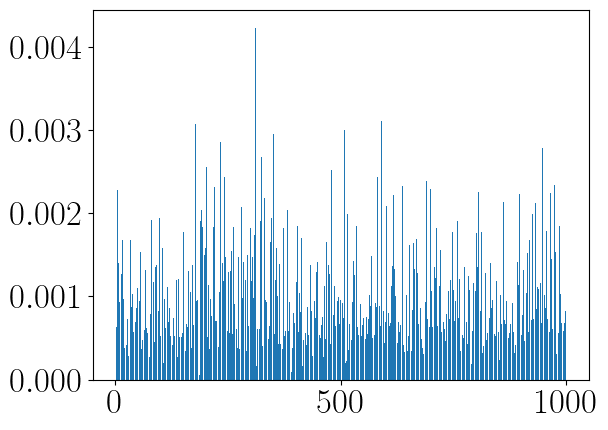

In [194]:
plt.bar(np.arange(K), a)
plt.show()

In [198]:
b = np.array([0.01, 0.02, 0.07, 0.9])
T, a, b = ot_on_coreset(1.0-coreset_scores, a=a, b=b, reg=0.1)
coreset_pred = np.argmax(T, axis=-1)
ot_pred = np.argmax(T[labels], axis=-1)

In [199]:
print("RVC CLASS DISTRIBUTION")
counts = Counter(y_pred)
total = len(y_pred)

for cls, count in counts.items():
    print(f"{label_encoder.inverse_transform([cls])[0]}: {count/total:.2f}")

print("")

print("CORESET CLASS DISTRIBUTION")
counts = Counter(coreset_pred)
total = len(coreset_pred)

for cls, count in counts.items():
    print(f"{label_encoder.inverse_transform([cls])[0]}: {count/total:.2f}")

print("")

print("RVC OT CLASS DISTRIBUTION")
counts = Counter(ot_pred)
total = len(ot_pred)

for cls, count in counts.items():
    print(f"{label_encoder.inverse_transform([cls])[0]}: {count/total:.2f}")

RVC CLASS DISTRIBUTION
Stationary: 0.68
Feeding: 0.21
Running: 0.04
Moving: 0.06

CORESET CLASS DISTRIBUTION
Stationary: 0.84
Running: 0.11
Moving: 0.02
Feeding: 0.02

RVC OT CLASS DISTRIBUTION
Stationary: 0.90
Running: 0.07
Feeding: 0.01
Moving: 0.02
